In [83]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# O2 flux

##### RUN:
/data/tjarniko/results/j17a
##### DATE:  Jan17_2019
##### description of point: 

calculate intermediate calculations for oxygen flux. 
check units/check that numbers make sense with literature



In [84]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [85]:
#import all the things

%reset
import netCDF4 as nc
import matplotlib.pyplot as plt
import datetime
import os
import numpy as np
import cmocean as cm
from salishsea_tools import visualisations as vis
from salishsea_tools import (teos_tools, tidetools, viz_tools)
import xarray as xr 
import subprocess 
import cmocean
from matplotlib import reload
import glob
import netCDF4 as nc
import VIZ_plots as VP

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Oxygen is exchanged with the atmosphere using the parameterization
of Wanninkhof (1992) to compute the gas exchange
coefficient. The atmospheric concentration of oxygen
is constant over time and space and cannot be specified by
the user. As for CO2, no air–sea fluxes are allowed when the
ocean is covered by sea ice (see Eq. 82).

In [86]:
reload(VP)

<module 'VIZ_plots' from '/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/VIZ/VIZ_plots.py'>

#### Available functions from VP

    two_panel_plot(surfdat_1,surfdat_2,tit1,tit2,t_cmap,xsize,ysize,vmin,vmax,clabel,bigtit)
    animate_surf(hrly_dat,tit,v_min,v_max,t_cmap)

In [87]:
resdir = '/data/tjarniko/results/j17a/'
#resdir = '/data/tjarniko/results/j17a/'
ptrc = 'SalishSea_1ts_20171026_20171026_ptrc_T.nc'
grid = 'SalishSea_1ts_20171026_20171026_grid_T.nc'
tracers = nc.Dataset(resdir + ptrc)
tracersp = nc.Dataset(resdir + grid)
#print(tracers)
# print(tracersp)

In [88]:
chemo2 = tracers.variables['of_chemo2'][0,:,:]
zkgo2 = tracers.variables['of_zkgo2'][0,:,:]
patm = tracers.variables['of_patm'][0,:,:]
patm = patm/101325
o2_surf = tracers.variables['dissolved_oxygen'][0,0,:,:]
oce_o2 = tracers.variables['oce_o2'][0,:,:]
wm = tracers.variables['wind_mag'][0,:,:]
sal = tracersp.variables['vosaline'][0,0,:,:]
temp = tracersp.variables['votemper'][0,0,:,:]


In [90]:
print('chemo2')
print(np.min(chemo2))
print(np.max(chemo2))
print('zkgo2')
print(np.min(zkgo2))
print(np.max(zkgo2))
print('patm')
print(np.min(patm))
print(np.max(patm))
print('oce_o2')
print(np.min(oce_o2))
print(np.max(oce_o2))
print('o2_surf')
print(np.min(o2_surf))
print(np.max(o2_surf))
print('wind_mag')
print(np.min(wm))
print(np.max(wm))


chemo2
0.000235424
0.000358105
zkgo2
0.0
4.86367e-05
patm
1.0050707809
1.0094251172
oce_o2
-0.0141842
0.0
o2_surf
0.0
475.181
wind_mag
0.0
8.5762


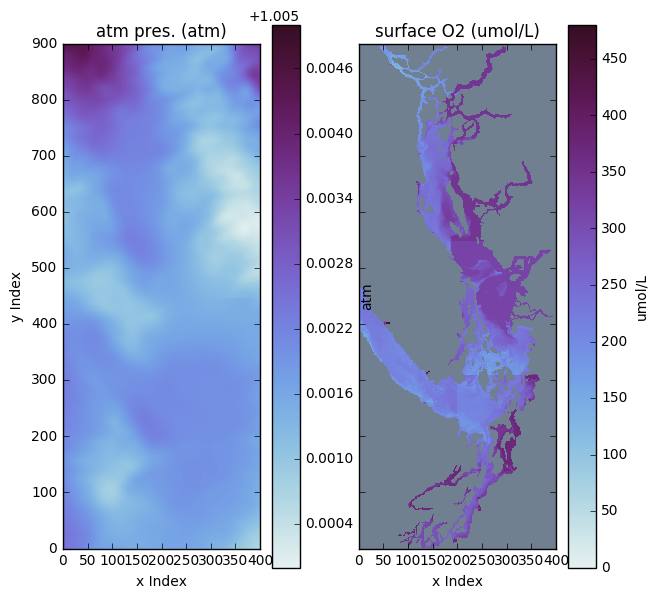

In [91]:
VP.two_panel_plot(patm,o2_surf,'atm pres. (atm)','surface O2 (umol/L)',\
                  cm.cm.dense,7,7,1.005,1.01,0,480,'atm','umol/L','')


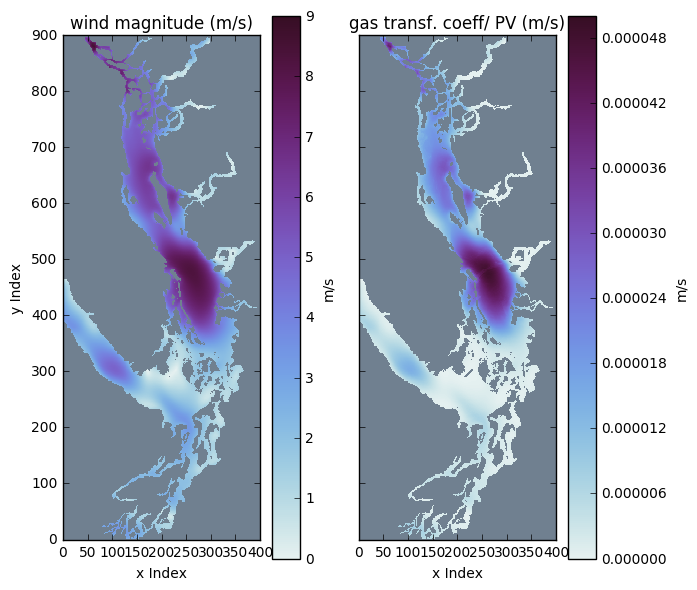

In [92]:
VP.two_panel_plot(wm,zkgo2,'wind magnitude (m/s)','gas transf. coeff/ PV (m/s)',\
                  cm.cm.dense,7,7,0,9,0,5e-5,'m/s','m/s','')


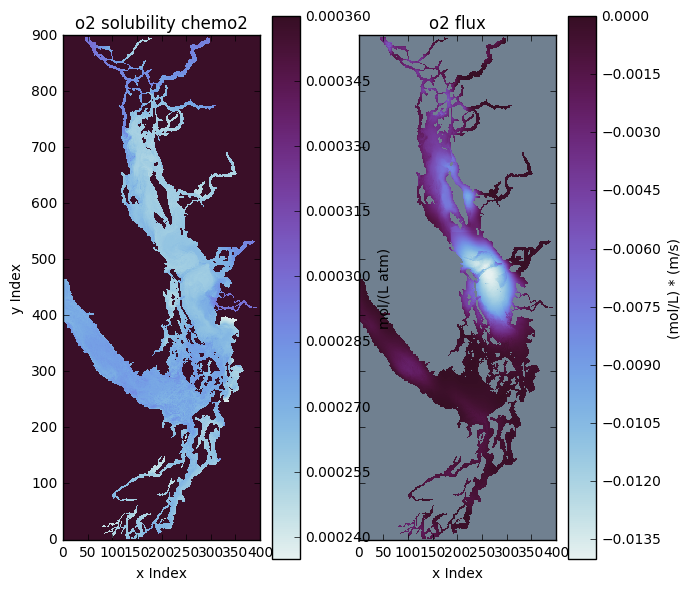

In [93]:
VP.two_panel_plot(chemo2,oce_o2,'o2 solubility chemo2','o2 flux',\
                  cm.cm.dense,7,7,.000235,.00036,-0.014,0,'mol/(L atm)','(mol/L) * (m/s)','')

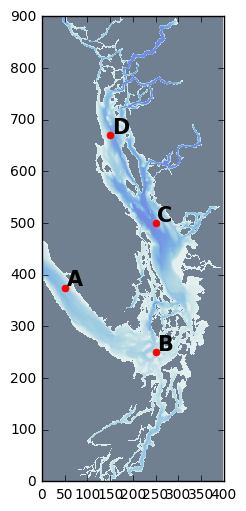

In [94]:
mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
bathy = mesh.variables['Bathymetry'][:]

itt = [50,250,250,150]
jtt = [375,250,500,670]
wtt = ['A','B','C','D']
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(bathy, cmap=cmocean.cm.dense, vmin = 0, vmax = 1000)
for w in range(0,len(wtt)):

        ax.plot(itt[w],jtt[w],'r.',markersize=10)
        ax.text(itt[w]+4,jtt[w]+4,wtt[w],fontsize=15,weight='bold')

In [97]:
#o2 conc, temp, sal, schmidt number, wind mag, pist_vel, 
itt = [50.0,250.0,250,150]
jtt = [375,250,500,670]
temptt = np.zeros_like(itt)
saltt = np.zeros_like(itt)
windtt = np.zeros_like(itt)
schtt = np.zeros_like(itt)
pisttt= np.zeros_like(itt)
o2_conc = np.zeros_like(itt)
o2_sol  = np.zeros_like(itt)
o2_flx = np.zeros_like(itt)
itt = [50,250,250,150]

for w in range(0,len(itt)):
    temptt[w] = temp[jtt[w],itt[w]]
    saltt[w]= sal[jtt[w],itt[w]]
    windtt[w]= wm[jtt[w],itt[w]]
    ztc = temptt[w]
    sc_o2  = 1920.4 - 135.6  * ztc + 5.2122 * ztc**2 - 0.109390 * ztc**3 + 0.0009377 * ztc**4
    schtt[w] = sc_o2
    pisttt[w] = zkgo2[jtt[w],itt[w]]
    o2_sol[w] = chemo2[jtt[w],itt[w]]
    o2_flx[w] = oce_o2[jtt[w],itt[w]]
    o2_conc[w] = o2_surf[jtt[w],itt[w]]


In [98]:
import pandas as pd
dataset = pd.DataFrame({'i':itt,'j':jtt,'temp (C)':temptt,\
                        'sal':saltt,'schmidt':schtt,'wind (m/s)':windtt,\
                       'pist.vel.(m/s)':pisttt,'o2 sol (mol/(L atm))':o2_sol,\
                        'o2 flux (mol/L) * (m/s)':o2_flx,'surface o2 (umol/L)':o2_conc})
print(dataset)


     i    j  o2 flux (mol/L) * (m/s)  o2 sol (mol/(L atm))  pist.vel.(m/s)  \
0   50  375                -0.000527              0.000276        0.000003   
1  250  250                -0.000362              0.000273        0.000002   
2  250  500                -0.011215              0.000259        0.000043   
3  150  670                -0.005124              0.000255        0.000024   

       sal     schmidt  surface o2 (umol/L)  temp (C)  wind (m/s)  
0  31.1875  867.797182           218.179443   12.1250    2.135901  
1  30.6875  833.850022           215.278244   12.8125    1.764489  
2  26.9375  684.662717           287.483734   16.3750    7.922366  
3  28.5625  668.979692           242.052902   16.8125    5.851653  
